## Context
Put the prerace and postrace into one dataframe and save

## Libraries

In [2]:
import os 
import pandas as pd
import re
from datetime import datetime

## Bring in Data

In [3]:
DATA_PATHS = {
    "prerace": "/Users/robpacey/Projects/2. Horse Racing/1. Betting Webscrape - Sportinglife/SportingLife/4. Data/1.Prerace",
    "result": "/Users/robpacey/Projects/2. Horse Racing/1. Betting Webscrape - Sportinglife/SportingLife/4. Data/2.Result",
}

In [4]:
def load_csvs_with_filename(file_list):
    """Load multiple CSVs into one DataFrame, adding SourceFile column."""
    dfs = []
    for f in file_list:
        try:
            df = pd.read_csv(f)
            df["SourceFile"] = os.path.basename(f)
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Skipping {f} ({e})")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [5]:
# --- Get file lists ---
prerace_files = [
    os.path.join(DATA_PATHS["prerace"], f)
    for f in os.listdir(DATA_PATHS["prerace"])
    if f.endswith(".csv")
]

postrace_files = [
    os.path.join(DATA_PATHS["result"], f)
    for f in os.listdir(DATA_PATHS["result"])
    if f.endswith(".csv")
]

In [6]:
# --- Load all files with filename column ---
df_prerace_all = load_csvs_with_filename(prerace_files)
df_postrace_all = load_csvs_with_filename(postrace_files)

## Keep Only the Latest Version in case of duplicates

In [7]:
# Sort by file date and keep the latest per RaceName
# --- Find the latest SourceFile for each race ---
latest_files = (
    df_prerace_all.sort_values(by=["RaceName", "SourceFile"], ascending=[True, False])
    .groupby("RaceName", as_index=False)
    .first()[["RaceName", "SourceFile"]]
)
latest_files_post = (
    df_postrace_all.sort_values(by=["RaceName", "SourceFile"], ascending=[True, False])
    .groupby("RaceName", as_index=False)
    .first()[["RaceName", "SourceFile"]]
)

# --- Keep all rows for those latest SourceFiles ---
df_prerace_latest = df_prerace_all.merge(latest_files, on=["RaceName", "SourceFile"], how="inner")
df_postrace_latest = df_postrace_all.merge(latest_files_post, on=["RaceName", "SourceFile"], how="inner")


## Merge

In [8]:
# Clean trailing numbers at the end of HorseName
df_prerace_latest["HorseName"] = (
    df_prerace_latest["HorseName"]
    .astype(str)
    .str.replace(r"\d+(\.\d+)?$", "", regex=True)  # remove trailing numbers like 31 or 31.0
    .str.strip()  # clean up any trailing spaces
)

In [9]:
merged_df = df_prerace_latest.merge(
    df_postrace_all, 
    on=["RaceLocation", "RaceDate", "RaceTime", "HorseName"], 
    how="left", 
    suffixes=("_Pre", "_Post")
)

In [10]:
# Fill information for Non Runners
# Identify the race-level _Post columns you want to fill
race_level_post_cols = [
    "RaceDayOfWeek_Post", "RaceName_Post", "WinningTime_Post",
    "RaceDistance_Post", "RaceGoing_Post", "RaceRunners_Post",
    "RaceSurface_Post", "SourceURL_Post", "SourceFile_Post"
]

# Fill missing _Post columns per race
merged_df[race_level_post_cols] = (
    merged_df
    .groupby(["RaceLocation", "RaceDate", "RaceTime"])[race_level_post_cols]
    .transform(lambda x: x.ffill().bfill())
    .infer_objects(copy=False)
)

/var/folders/7f/0h8h7xz956bdtmcfl6hvf10h0000gn/T/ipykernel_32722/1637626705.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.ffill().bfill())


## Save

In [54]:
today_str = datetime.today().strftime("%Y%m%d_%H%M")
filepath = '/Users/robpacey/Projects/2. Horse Racing/1. Betting Webscrape - Sportinglife/SportingLife/4. Data/3.Merge'
filename = f"{today_str}_merged.csv"
save_location = f"{filepath}/{filename}"

merged_df.to_csv(save_location, index=False)

## Checks

In [42]:
missing_post = merged_df[merged_df["SourceURL_Post"].isna()]  # or any postrace-specific column
print(f"❌ Missing post-race data for {len(missing_post)} races")

❌ Missing post-race data for 849 races


In [43]:
missing_post_dates2 = missing_post[["RaceDate","RaceLocation","RaceTime"]].drop_duplicates()
missing_post_dates2.head()

,RaceDate,RaceLocation,RaceTime
8851,12/03/2024,Southwell,18:00
12283,25/02/2024,Hereford,16:45
16758,05/10/2025,Killarney,16:09
42592,18/10/2024,Haydock,17:15
57011,05/06/2025,Lingfield,16:57


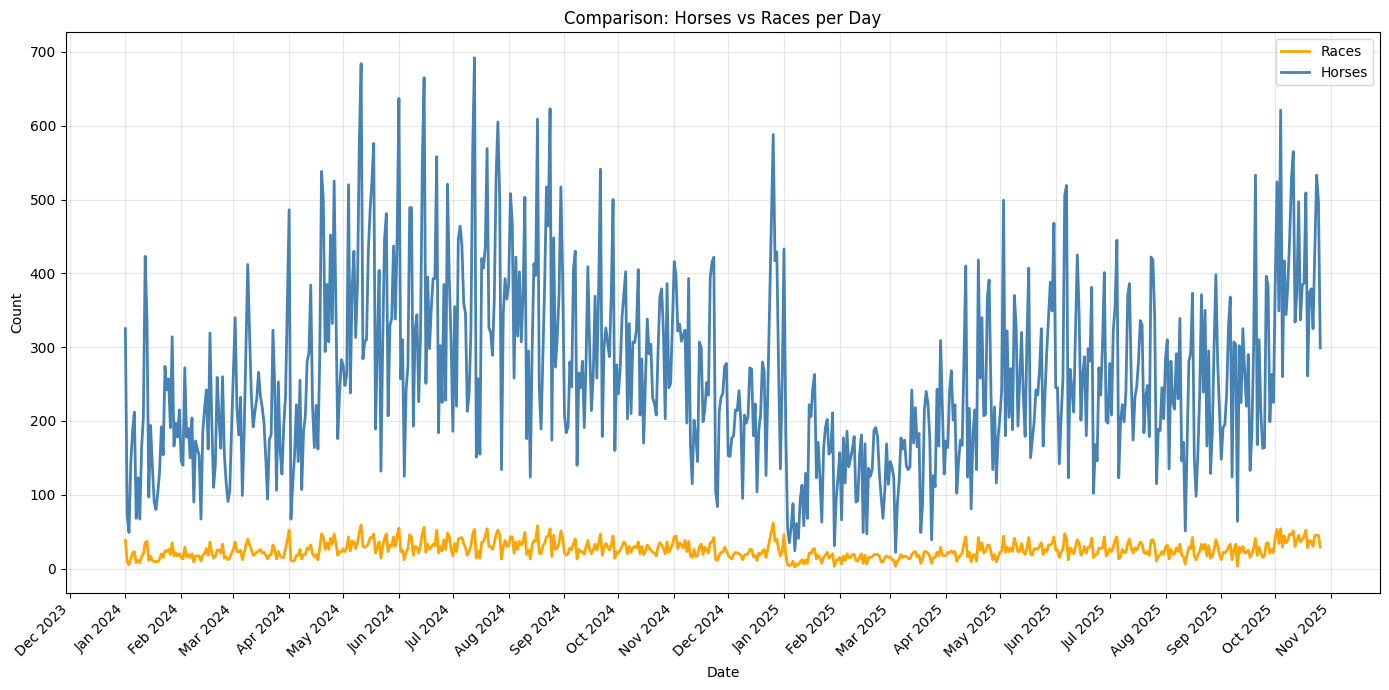

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure RaceDate is a datetime
merged_df["RaceDate"] = pd.to_datetime(merged_df["RaceDate"], errors="coerce")

# --- Count unique races per day ---
race_counts = (
    merged_df.groupby("RaceDate")["RaceName_Pre"]
    .nunique()
    .reset_index(name="RaceCount")
)

# --- Count unique horses per day ---
horse_counts = (
    merged_df.groupby("RaceDate")["HorseName"]
    .nunique()
    .reset_index(name="HorseCount")
)

# --- Merge both counts ---
daily_counts = pd.merge(race_counts, horse_counts, on="RaceDate", how="outer").fillna(0)
daily_counts = daily_counts.sort_values("RaceDate")

# --- Plot ---
plt.figure(figsize=(14, 7))
plt.plot(daily_counts["RaceDate"], daily_counts["RaceCount"], label="Races", color="orange", linewidth=2)
plt.plot(daily_counts["RaceDate"], daily_counts["HorseCount"], label="Horses", color="steelblue", linewidth=2)

# Format x-axis to show one tick per month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.title("Comparison: Horses vs Races per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
df = merged_df[merged_df["RaceLocation"] == 'Wolverhampton']
df = df[df["RaceDate"] == '19/04/2025']
df = df[["RaceDate","RaceLocation","RaceTime"]].drop_duplicates()
df.head()

,RaceDate,RaceLocation,RaceTime
26113,19/04/2025,Wolverhampton,20:00
26126,19/04/2025,Wolverhampton,17:55
26138,19/04/2025,Wolverhampton,17:20


In [14]:
df = df_prerace_all[df_prerace_all["RaceLocation"] == 'Wolverhampton']
df = df[df["RaceDate"] == '19/04/2025']
df = df[["RaceDate","RaceLocation","RaceTime"]].drop_duplicates()
df.head()

,RaceDate,RaceLocation,RaceTime
33984,19/04/2025,Wolverhampton,20:30
33994,19/04/2025,Wolverhampton,20:00
34007,19/04/2025,Wolverhampton,19:30
34014,19/04/2025,Wolverhampton,19:00
34020,19/04/2025,Wolverhampton,18:30


In [16]:
df = df_postrace_all[df_postrace_all["RaceLocation"] == 'Wolverhampton']
df = df[df["RaceDate"] == '19/04/2025']
df = df[["RaceDate","RaceLocation","RaceTime"]].drop_duplicates()
df.head()

,RaceDate,RaceLocation,RaceTime
212452,19/04/2025,Wolverhampton,20:30
212459,19/04/2025,Wolverhampton,20:00
212471,19/04/2025,Wolverhampton,19:30
212478,19/04/2025,Wolverhampton,19:00
212484,19/04/2025,Wolverhampton,18:30
